# Importing all Libraries


In [22]:
import json
import random
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, LayerNormalization, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import plot_model


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vincent\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vincent\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Open File Json

In [23]:
with open('intents.json', 'r') as f:
    data = json.load(f)

df = pd.DataFrame(data['intents'])
df

,tag,patterns,responses
0,greeting,"[Hi, Hey, Is anyone there?, Hi there, Hello, H...",[Hello there. Tell me how are you feeling toda...
1,morning,[Good morning],[Good morning. I hope you had a good night's s...
2,afternoon,[Good afternoon],[Good afternoon. How is your day going?]
3,evening,[Good evening],[Good evening. How has your day been?]
4,night,[Good night],"[Good night. Get some proper sleep, Good night..."
...,...,...,...
125,i want to leave the cou ntry and run away,[i want to leave the cou ntry and run away],[why do you want to spend so much on this thou...
126,i let everyojokne down,[i let everyojokne down],[if you are the one who let them down you were...
127,i can't do this anymore,[i can't do this anymore],[if you are really that exhausted you definite...
128,my time has come,[my time has come],[yeahh!! the time has come for you to show the...


In [24]:
dic = {"tag":[], "patterns":[], "responses":[]}
for i in range(len(df)):
    ptrns = df[df.index == i]['patterns'].values[0]
    rspns = df[df.index == i]['responses'].values[0]
    tag = df[df.index == i]['tag'].values[0]
    for j in range(len(ptrns)):
        dic['tag'].append(tag)
        dic['patterns'].append(ptrns[j])
        dic['responses'].append(rspns)

df = pd.DataFrame.from_dict(dic)
df

,tag,patterns,responses
0,greeting,Hi,[Hello there. Tell me how are you feeling toda...
1,greeting,Hey,[Hello there. Tell me how are you feeling toda...
2,greeting,Is anyone there?,[Hello there. Tell me how are you feeling toda...
3,greeting,Hi there,[Hello there. Tell me how are you feeling toda...
4,greeting,Hello,[Hello there. Tell me how are you feeling toda...
...,...,...,...
278,i want to leave the cou ntry and run away,i want to leave the cou ntry and run away,[why do you want to spend so much on this thou...
279,i let everyojokne down,i let everyojokne down,[if you are the one who let them down you were...
280,i can't do this anymore,i can't do this anymore,[if you are really that exhausted you definite...
281,my time has come,my time has come,[yeahh!! the time has come for you to show the...


# data preparation


# Data Processing

In [25]:
df['tag'].unique()

array(['greeting', 'morning', 'afternoon', 'evening', 'night', 'goodbye',
       'thanks', 'no-response', 'neutral-response', 'about',
       'what is depression?', 'skill', 'creation', 'help', 'sad',
       'stressed', 'worthless', 'depressed', 'happy', 'casual', 'anxious',
       'not-talking', 'sleep', 'scared', 'death', 'understand', 'done',
       'suicide', 'hate-you', 'hate-me', 'default', 'jokes', 'repeat',
       'wrong', 'stupid', 'location', 'something-else', 'friends', 'ask',
       'problem', 'no-approach', 'learn-more', 'user-agree', 'meditation',
       'user-meditation', 'jamila-useful', 'user-advice',
       'learn-mental-health', 'mental-health-fact', 'fact-1', 'fact-2',
       'fact-3', 'fact-5', 'fact-6', 'fact-7', 'fact-8', 'fact-9',
       'fact-10', 'fact-11', 'fact-12', 'fact-13', 'fact-14', 'fact-15',
       'fact-16', 'fact-17', 'fact-18', 'fact-19', 'fact-20', 'fact-21',
       'fact-22', 'fact-23', 'fact-24', 'fact-25', 'fact-26', 'fact-27',
       'fact-28'

Cleaning Text

In [26]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return ' '.join(tokens)

Cleaning Pattern

In [27]:
df['cleaned_patterns'] = df['patterns'].apply(clean_text)

In [28]:
print("\nOriginal Patterns:")
for p in df['patterns'][:5]:  # Menampilkan contoh dari pola awal
    print(p)


Original Patterns:
Hi
Hey
Is anyone there?
Hi there
Hello


In [29]:
print("\nCleaned Patterns:")
for cp in df['cleaned_patterns'][:5]:  # Menampilkan contoh dari pola yang telah dibersihkan
    print(cp)


Cleaned Patterns:
hi
hey
anyone
hi
hello


#Contoh

In [30]:
kata = ('Chatbots in mental health provide immediate support and resources for individuals struggling with anxiety and depression.')
kata2 = clean_text(kata)
print('kalimat sebelum di clean: ', kata)
print('kalimat setelah di clean: ', kata2)

kalimat sebelum di clean:  Chatbots in mental health provide immediate support and resources for individuals struggling with anxiety and depression.
kalimat setelah di clean:  chatbots mental health provide immediate support resources individuals struggling anxiety depression


In [31]:

tokenizer = Tokenizer(lower=True, split=' ')
tokenizer.fit_on_texts(df['cleaned_patterns'])
tokenizer.get_config()

{'num_words': None,
 'filters': '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
 'lower': True,
 'split': ' ',
 'char_level': False,
 'oov_token': None,
 'document_count': 283,
 'word_counts': '{"hi": 2, "hey": 2, "anyone": 2, "hello": 1, "howdy": 1, "hola": 1, "bonjour": 1, "hay": 1, "sasa": 1, "good": 9, "evening": 2, "afternoon": 2, "morning": 1, "night": 1, "bye": 3, "see": 2, "later": 1, "goodbye": 1, "au": 1, "revoir": 1, "sayonara": 1, "ok": 4, "fare": 1, "thee": 1, "well": 2, "thanks": 2, "thank": 3, "thats": 3, "helpful": 1, "help": 6, "much": 4, "nothing": 7, "really": 3, "tell": 6, "name": 2, "call": 1, "whats": 3, "depression": 22, "created": 2, "made": 1, "could": 2, "give": 1, "hand": 1, "please": 2, "need": 6, "support": 3, "feeling": 3, "lonely": 5, "feel": 18, "sad": 4, "empty": 1, "dont": 11, "stressed": 6, "stuck": 1, "still": 1, "burned": 1, "worthless": 1, "one": 2, "likes": 2, "cant": 8, "anything": 2, "useless": 2, "makes": 1, "sense": 2, "anymore": 3, "take": 1, "depres

Conversion Label to Number


In [32]:
ptrn2seq = tokenizer.texts_to_sequences(df['patterns'])
X = pad_sequences(ptrn2seq, padding='post')
print('X shape = ', X.shape)

lbl_enc = LabelEncoder()
y = lbl_enc.fit_transform(df['tag'])
print('y shape = ', y.shape)
print('num of classes = ', len(np.unique(y)))

X shape =  (283, 9)
y shape =  (283,)
num of classes =  129


# Train Test Split

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [34]:
vocab_size = len(tokenizer.word_index)
print('number of unique words = ', vocab_size)

number of unique words =  292


In [35]:
from tensorflow.keras.layers import Input, Embedding, LSTM, LayerNormalization, Dense, Dropout
from tensorflow.keras.models import Model

# Assuming X is your input data with shape (number_of_samples, sequence_length)
input_shape = (X.shape[1],)  # Shape tuple

# Define the model
model = Sequential()
model.add(Embedding(input_dim=vocab_size + 1, output_dim=100, mask_zero=True, input_shape=input_shape))
model.add(LSTM(32, return_sequences=True))
model.add(LayerNormalization())
model.add(LSTM(32, return_sequences=True))
model.add(LayerNormalization())
model.add(LSTM(32))
model.add(LayerNormalization())
model.add(Dense(128, activation="relu"))
model.add(LayerNormalization())
model.add(Dropout(0.2))
model.add(Dense(128, activation="relu"))
model.add(LayerNormalization())
model.add(Dropout(0.2))
model.add(Dense(len(np.unique(y)), activation="softmax"))

# Compile the model
model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])

# Print model summary and plot model architecture
model.summary()
plot_model(model, show_shapes=True)


c:\Users\vincent\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 9, 100)         │        29,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 9, 32)          │        17,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_5           │ (None, 9, 32)          │            64 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 9, 32)          │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_6           │ (None, 9, 32)          │            64 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_7           │ (None, 32)             │            64 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_8           │ (None, 128)            │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_9           │ (None, 128)            │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 129)            │        16,641 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,045 (394.71 KB)

 Trainable params: 101,045 (394.71 KB)

 Non-trainable params: 0 (0.00 B)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [36]:
model_history = model.fit(x=X_train,
                          y=y_train,
                          batch_size=10,
                          callbacks=[tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)],
                          validation_split=0.2,
                          epochs=50)
model.save('model.h5')

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - accuracy: 0.0334 - loss: 5.3046 - val_accuracy: 0.0217 - val_loss: 5.1643
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1441 - loss: 4.1218 - val_accuracy: 0.0652 - val_loss: 5.0468
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3170 - loss: 3.3189 - val_accuracy: 0.0652 - val_loss: 4.9542
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4484 - loss: 2.6884 - val_accuracy: 0.0652 - val_loss: 5.0714
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5980 - loss: 2.1686 - val_accuracy: 0.0870 - val_loss: 5.1301
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7042 - loss: 1.7469 - val_accuracy: 0.0652 - val_loss: 5.1732
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7560 - loss: 1.5470 - val_accuracy: 0.1304 - val_loss: 5.1995
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7923 - loss: 1.2512 - val_accuracy: 0.1087 - 

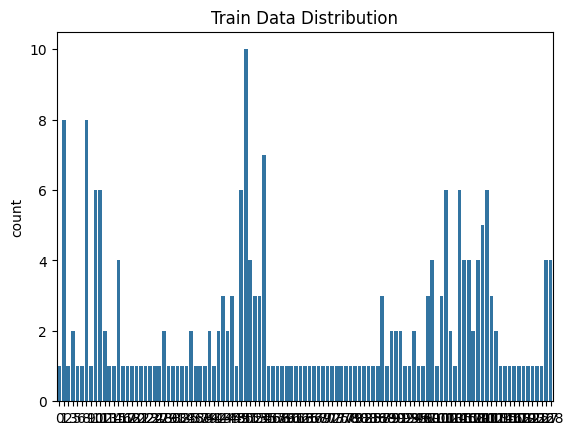

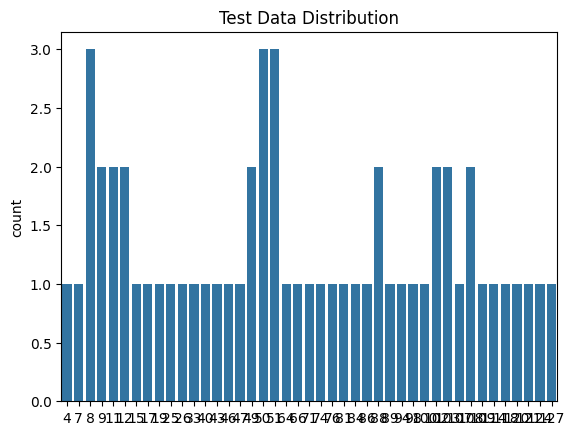

In [37]:
import seaborn as sns

sns.countplot(x=y_train)
plt.title('Train Data Distribution')
plt.show()

sns.countplot(x=y_test)
plt.title('Test Data Distribution')
plt.show()


In [38]:
#Model untuk KNN
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X, y)

KNeighborsClassifier()

In [39]:
#Model untuk Random Forest
rf_classifier = RandomForestClassifier(
    n_estimators=200,
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
    random_state=42,
)
rf_classifier.fit(X, y)

RandomForestClassifier(n_estimators=200, random_state=42)

In [40]:
y_pred = rf_classifier.predict(X_test)

In [41]:
# Evaluate the model's performance
report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

# Convert float values in the report to dictionaries
report = {label: {metric: report[label][metric] for metric in report[label]} for label in report if isinstance(report[label], dict)}

# Extract evaluation metrics
labels = list(report.keys())
evaluation_metrics = ['precision', 'recall', 'f1-score']
metric_scores = {metric: [report[label][metric] for label in labels if label in report] for metric in evaluation_metrics}

# Visualize the model's performance using a Plotly bar plot
fig = go.Figure()
for metric in evaluation_metrics:
    fig.add_trace(go.Bar(name=metric, x=labels, y=metric_scores[metric]))

fig.update_layout(title='Intent Prediction Model Performance',
                  xaxis_title='Intent',
                  yaxis_title='Score',
                  barmode='group')

fig.show()

NameError: name 'classification_report' is not defined

In [ ]:
#Model untuk SVM
svm_classifier = SVC(kernel='linear', C=1.0)
svm_classifier.fit(X, y)

SVC(kernel='linear')

# Metric Evaluation

In [ ]:
# Fungsi untuk mendapatkan prediksi dan metrik evaluasi
def evaluate_model(classifier, X_test, y_test):
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted')
    return accuracy, precision, recall, f1

Pembuatan Tabel Data Frame

In [ ]:
results_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

In [ ]:
def add_to_results(model_name, accuracy, precision, recall, f1):
    results_df.loc[len(results_df)] = [model_name, accuracy, precision, recall, f1]

In [ ]:
# Evaluasi model KNN
knn_accuracy, knn_precision, knn_recall, knn_f1 = evaluate_model(knn_classifier, X_test, y_test)
add_to_results('KNN', knn_accuracy, knn_precision, knn_recall, knn_f1)

In [ ]:
# Evaluasi model Random Forest
rf_accuracy, rf_precision, rf_recall, rf_f1 = evaluate_model(rf_classifier, X_test, y_test)
add_to_results('Random Forest', rf_accuracy, rf_precision, rf_recall, rf_f1)

In [ ]:
# Evaluasi model SVM
svm_accuracy, svm_precision, svm_recall, svm_f1 = evaluate_model(svm_classifier, X_test, y_test)
add_to_results('SVM', svm_accuracy, svm_precision, svm_recall, svm_f1)

In [ ]:
# Cetak hasil evaluasi dalam bentuk tabel
print("\nHasil Evaluasi Model:")
print(results_df)


Hasil Evaluasi Model:
           Model  Accuracy  Precision    Recall  F1 Score
0            KNN  0.228070   0.239766  0.228070  0.221637
1  Random Forest  0.894737   0.938596  0.894737  0.907602
2            SVM  0.368421   0.347687  0.368421  0.344194


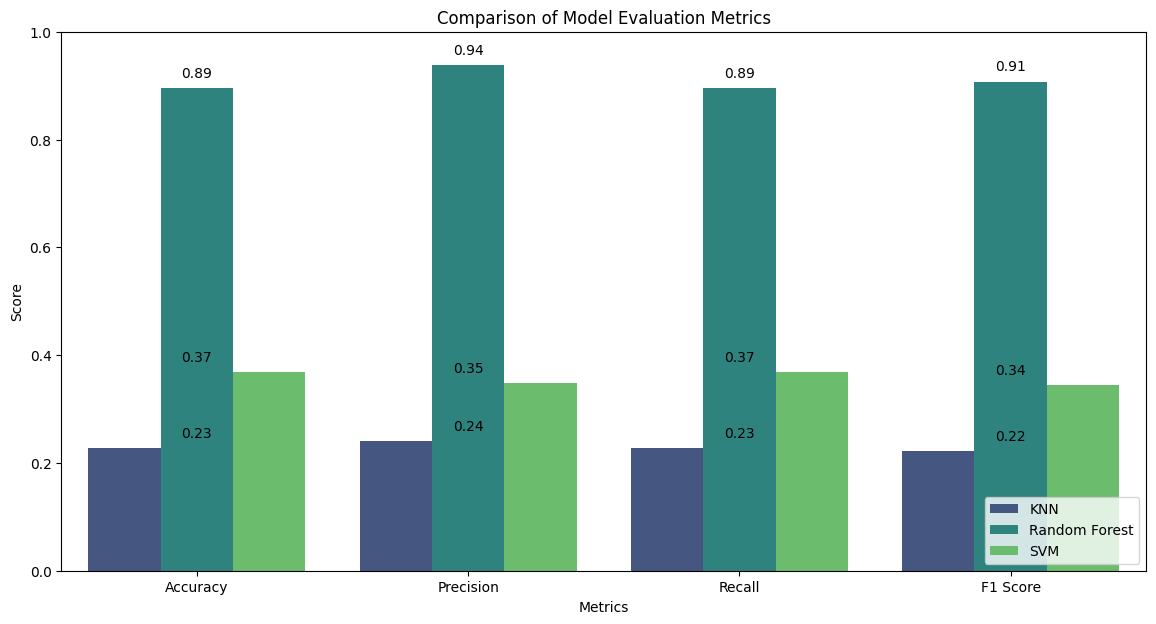

In [ ]:
import seaborn as sns

def plot_evaluation_results(df):
    plt.figure(figsize=(14, 7))
    sns.barplot(data=df.melt(id_vars='Model', var_name='Metrics', value_name='Score'), x='Metrics', y='Score', hue='Model', palette='viridis')
    plt.title('Comparison of Model Evaluation Metrics')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    for index, row in df.iterrows():
        for i, val in enumerate(row[1:]):
            plt.text(i, val + 0.02, f"{val:.2f}", ha='center')
    plt.legend(loc='lower right')
    plt.show()

# Visualisasi hasil evaluasi
plot_evaluation_results(results_df)

# Testing the response chatbot

In [ ]:
def get_response_lstm(input_text):
    # Pembersihan teks
    input_clean = clean_text(input_text)
    # Tokenisasi dan padding teks input
    input_sequence = tokenizer.texts_to_sequences([input_clean])
    input_padded = pad_sequences(input_sequence, maxlen=X.shape[1], padding='post')

    # Prediksi menggunakan model LSTM
    prediction = model.predict(input_padded)
    predicted_index = np.argmax(prediction, axis=1)[0]

    # Dapatkan label intent yang diprediksi
    intent_label = lbl_enc.inverse_transform([predicted_index])[0]

    # Pilih respons acak yang sesuai dengan label intent
    response = random.choice([res for intent in data['intents'] if intent['tag'] == intent_label for res in intent['responses']])

    return response

In [ ]:
# Fungsi untuk mendapatkan respons dari Random Forest
def get_response_rf(input_text):
    input_clean = clean_text(input_text)
    input_sequence = tokenizer.texts_to_sequences([input_clean])
    input_padded = pad_sequences(input_sequence, maxlen=X.shape[1], padding='post')
    prediction = rf_classifier.predict(input_padded)
    intent_label = lbl_enc.inverse_transform([prediction])[0]
    response = random.choice([res for intent in data['intents'] if intent['tag'] == intent_label for res in intent['responses']])
    return response

In [ ]:
# Fungsi untuk mendapatkan respons dari SVM
def get_response_svm(input_text):
    input_clean = clean_text(input_text)
    input_sequence = tokenizer.texts_to_sequences([input_clean])
    input_padded = pad_sequences(input_sequence, maxlen=X.shape[1], padding='post')
    prediction = svm_classifier.predict(input_padded)
    intent_label = lbl_enc.inverse_transform([prediction])[0]
    response = random.choice([res for intent in data['intents'] if intent['tag'] == intent_label for res in intent['responses']])
    return response

In [ ]:
# Interaksi dengan pengguna
while True:
    user_input = input("You: ")
    if user_input.lower() == 'quit':
        break
    bot_response_knn = get_response_lstm(user_input)
    bot_response_rf = get_response_rf(user_input)
    bot_response_svm = get_response_svm(user_input)
    print("Bot (LSTM):", bot_response_knn)
    print("Bot (Random Forest):", bot_response_rf)
    print("Bot (SVM):", bot_response_svm)

KeyboardInterrupt: Interrupted by user

In [ ]:
%%writefile app.py


import streamlit as st

def main():
# Streamlit App
  st.title("Chatbot Mental Health")

  # Initialize chat history
  if "messages" not in st.session_state:
      st.session_state.messages = []

  # Display chat messages from history on app rerun
  for message in st.session_state.messages:
      with st.chat_message(message["role"]):
          st.markdown(message["content"])

  # Accept user input
  if prompt := st.chat_input("What is up?"):
      # Add user message to chat history
      st.session_state.messages.append({"role": "user", "content": prompt})
      # Display user message in chat message container
      with st.chat_message("user"):
          st.markdown(prompt)

      # Get assistant response
      response = get_response_lstm(prompt)
      # Add assistant response to chat history
      st.session_state.messages.append({"role": "assistant", "content": response})
      # Display assistant response in chat message container
      with st.chat_message("assistant"):
          st.markdown(response)
  if __name__ == "__main__":
      main()

Writing app.py


In [ ]:
!npm install localtunnel

npm WARN saveError ENOENT: no such file or directory, open '/content/package.json'
npm notice created a lockfile as package-lock.json. You should commit this file.
npm WARN enoent ENOENT: no such file or directory, open '/content/package.json'
npm WARN content No description
npm WARN content No repository field.
npm WARN content No README data
npm WARN content No license field.

+ localtunnel@2.0.2
added 22 packages from 22 contributors and audited 22 packages in 3.845s

3 packages are looking for funding
  run `npm fund` for details

found 1 moderate severity vulnerability
  run `npm audit fix` to fix them, or `npm audit` for details


In [ ]:
!wget -q -O - ipv4.icanhazip.com

34.106.27.59


In [ ]:
!streamlit run app.py & npx localtunnel --port 8501




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.106.27.59:8501

npx: installed 22 in 2.977s
your url is: https://plenty-waves-open.loca.lt
